In [1]:
import numpy as np
import numpy.random as rnd
import cv2
import scipy.stats as stats
from scipy.stats import multivariate_normal
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob
import pickle
import time
import pdb
from sklearn.metrics import accuracy_score
import seaborn as sb
import os
import sys

ModuleNotFoundError: No module named 'cv2'

In [44]:
class GMM():
    def __init__(self, data, K):
        self.data = data
        self.K = K
        self.D = self.data.shape[1]
        self.n = self.data.shape[0]
        self.lamda = np.ones((self.K))/self.K
        self.mu = np.zeros((self.K,self.D))

        for k in range(self.K):
            point = random.choice(self.data)
            self.mu[k] = point
            
        covariance = np.cov(self.data.T)
        self.cov = np.zeros((self.K,self.D,self.D))
        self.cov[:] = covariance
        
        self.r = np.zeros((self.n, self.K))

    def e_step(self):
        K = self.K
        n = self.n
        self.new_norm()
        
        for i, data_point in enumerate(self.data):
            for k in range(K):
                self.r[i,k] = self.lamda[k]*self.norm[k].pdf(data_point)
            self.r[i,:] /= self.r[i, :].sum()
            np.round(self.r[i,:],4)
        
    def m_step(self):
        K = self.K
        D = self.D
        n = self.n
        r_sum = self.r.sum(0)
        self.lamda = r_sum/float(self.r.sum())

        for k in range(K):
            self.mu[k] = self.r[:,k].dot(self.data)/r_sum[k]
        for k in range(K):
            temp = np.zeros((D, D))
            for i in range(n):
                t = self.data[i, :] - self.mu[k]
                temp += self.r[i,k]*np.outer(t,t)
            self.cov[k] = temp/r_sum[k]
    
    def train(self, tol=0.01, max_epoch=30):
        d = tol
        epoch = 0
        while ((d >= tol) and (epoch != max_epoch)):
            old_mu = self.mu.copy()
            self.e_step()
            self.m_step()
            d = np.linalg.norm(old_mu - self.mu)
            print(epoch, d)
            epoch += 1
    
    def new_norm(self):
        K = self.K
        self.norm = []
        for k in range(K):
            self.norm.append(multivariate_normal(mean=self.mu[k], cov=self.cov[k]))
        
    def check_image(self, check_image):
        tot = np.zeros((check_image.shape[:-1]))
        K = self.K
        for k in range(K):
            tot += self.lamda[k] * multivariate_normal(mean=self.mu[k], cov=self.cov[k]).pdf(check_image)
        return tot

In [45]:
data = np.array([[255.0], [255.0], [1.0], [3.0], [3.0]])
gmm = GMM(data, 2)
gmm.lamda[0] = 0.5
gmm.lamda[1] = 0.5
gmm.mu[0] = 255.0
gmm.mu[1] = 20.0
gmm.cov[0] = 10.0
gmm.cov[1] = 10.0
gmm.e_step()
print(gmm.r)

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [46]:
data = np.array([[255], [255], [1], [3], [3]])
gmm.r = np.array([[0.606, 0.394], [0.593, 0.407], [0.402, 0.598], [0.378, 0.622], [0.563, 0.437]])
gmm.m_step()
print(gmm.lamda)
print(gmm.mu)
print(gmm.cov)

[0.5084 0.4916]
[[121.54602675]
 [ 84.63384866]]
[[[15900.77502552]]

 [[14031.23452555]]]


In [47]:
data = np.array([[-2], [5], [7], [14], [15]])
gmm = GMM(data, 2)
gmm.lamda[0] = 0.3
gmm.lamda[1] = 0.7
gmm.mu[0] = 15.0
gmm.mu[1] = 0.0
gmm.cov[0] = 5.0
gmm.cov[1] = 5.0
gmm.e_step()
print(gmm.r)

[[1.79734100e-13 1.00000000e+00]
 [2.36979986e-04 9.99763020e-01]
 [8.72807927e-02 9.12719207e-01]
 [9.99999992e-01 7.92929152e-09]
 [1.00000000e+00 3.94776182e-10]]


In [56]:
np.round(8.72807927e-02,4)

0.0873

In [18]:
data = np.array([[-2], [5], [7], [14], [15]])
gmm.r = np.array([[0.300, 0.700], [0.200, 0.800], [0.250, 0.750], [0.600, 0.400], [0.700, 0.300]])
gmm.m_step()
print(gmm.lamda)
print(gmm.mu)
print(gmm.cov)

[0.41 0.59]
[[10.26829268]
 [ 6.08474576]]
[[[37.75728733]]

 [[32.6199368 ]]]


In [9]:
# if you get an image run this part
///

SyntaxError: invalid syntax (<ipython-input-9-a73bfb1eadc0>, line 2)

In [2]:
get_from = 'Training/'
image_filenames = sorted(glob.glob(get_from+'t*.jpg'))

training_images = []
for filename in image_filenames:
    BGR = cv2.imread(filename)
    HSV = cv2.cvtColor(BGR, cv2.COLOR_BGR2HSV)
    training_images.append(HSV)
    

In [3]:
def get_images(image_path, mask_path):
    imgBGR = cv2.imread(image_path)
    imgHSV = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2HSV)
    
    imgHSV = imgHSV.astype(float)
    imgBGR = imgBGR.astype(float)

    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    return imgHSV, mask

def get_pixels(img, mask):
    coin_pixels = img[(mask > 128).nonzero()]
    desk_pixels = img[(mask <= 128).nonzero()]
    return coin_pixels, desk_pixels
    
def get_prior(img, mask):
    ncoin = np.sum(mask > 128)
    ndesk = np.sum(mask <= 128)
    prior = ncoin/(ncoin + ndesk)
    return prior

In [4]:
training = sorted(glob.glob('Training/*.jpg'))
maskes = sorted(glob.glob('Label/*.png'))

def get_cd_pixels(num_images):
    prior = 0
    for i in range(num_images):
        image, mask = get_images(training[i], maskes[i])
        if(i == 0):
            coin_pixels, desk_pixels = get_pixels(image, mask)
            prior = get_prior(image, mask)
        else:
            curr_coin_pixels, curr_desk_pixels = get_pixels(image, mask)
            coin_pixels = np.vstack((coin_pixels, curr_coin_pixels))
            desk_pixels = np.vstack((desk_pixels, curr_desk_pixels))
            prior += get_prior(image, mask)
    return coin_pixels, desk_pixels,prior


In [6]:
coin_pixels, desk_pixels, prior = get_cd_pixels(3)

In [7]:
gmms = []
for i in range(2, 11):
    print(i)
    pkl = open("gmm"+str(i)+".pickle","wb")
    gmm = GMM(coin_pixels, i)
    gmm.train()
    pickle.dump(gmm, pkl)
    gmms.append(gmm)
    pkl.close()

pkl = open("gmm.pickle","wb")
pickle.dump(gmms, pkl)
pkl.close()

9
0 56.37279616728954
1 15.564960423656357
2 9.507513196347812
3 6.248391844045424
4 8.835798365857876
5 8.137206748950902
6 6.309514726198054
7 4.971417838330323
8 4.650194214276654
9 4.762440974603368
10 4.715136915673846
11 4.692384335270869
12 4.86824772239505
13 5.331722378092929
14 5.4127445417496425
15 5.671517111654912
16 5.1285207960953825
17 2.731166045134495
18 1.5801531324882523
19 1.351394896298442


In [76]:
cov_desk = np.cov(desk_pixels.T)
mu_desk = np.mean(desk_pixels, 0)    

acc = 0
test_images = sorted(glob.glob("Testing/Test_Image/*.jpg"))
test_maskes = sorted(glob.glob("Testing/Test_Mask/*.png"))
for i in range(2, 11):
    pickle_off = open("gmm"+str(i)+".pickle","rb")
    gmm = pickle.load(pickle_off)
    
    index = 3
    image, mask = get_images(test_images[index], test_maskes[index])

    likelihood = gmm.check_image(image)
    num = prior*likelihood
    den = num + ((1-prior)*multivariate_normal(mean=mu_desk, cov=cov_desk).pdf(image))
    prob = num/den

    prob[prob>=0.5] = 255
    prob[prob<0.5] = 0

    prob = prob.ravel().astype(int)
    mask = mask.ravel()
    curr_acc = accuracy_score(mask, prob)
    print(curr_acc)
    

0.9835953776041667
0.9765657552083333
0.9795719401041667
0.9751106770833333
0.9759757486979167
0.9803483072916667
0.9727685546875
0.98015625
0.97817626953125


C:\Users\uvir1\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


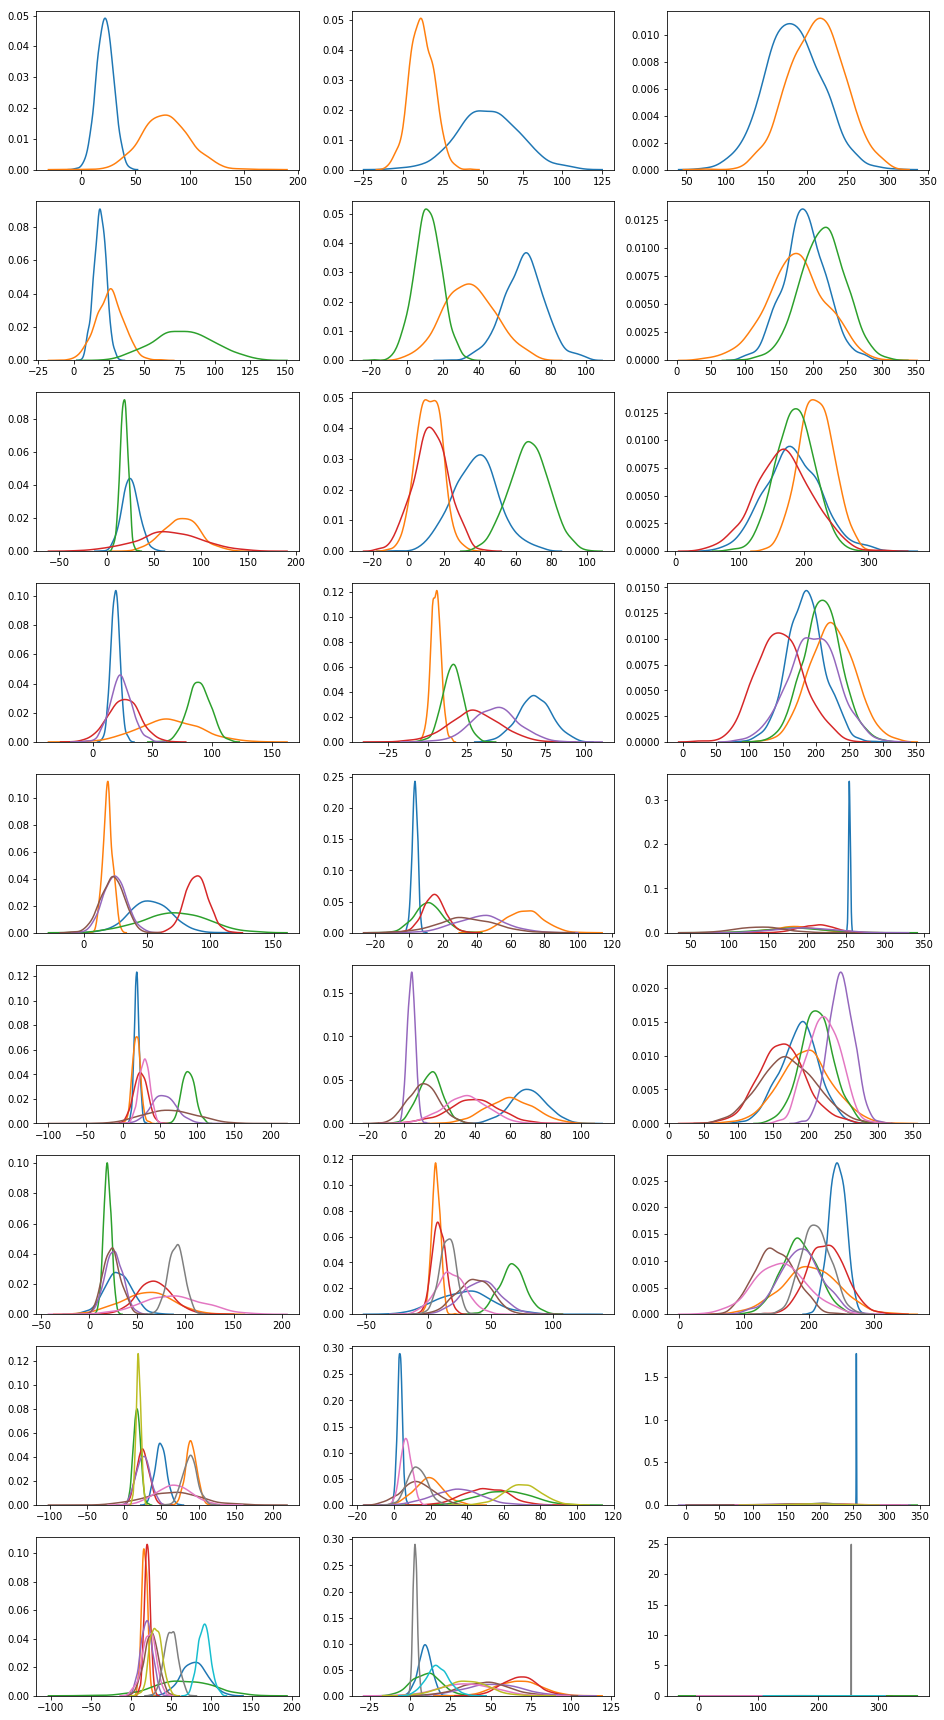

In [77]:
fig, axis = plt.subplots(9, 3, figsize=(16, 31))
for g in range(2, 11):
    pickle_off = open("gmm"+str(g)+".pickle","rb")
    gmm = pickle.load(pickle_off)
    for k in range(g):
        for j in range(3):
            dist = np.random.normal(gmm.mu[k, j], np.sqrt(gmm.cov[k, j, j]), 1000)
            sb.kdeplot(dist, ax=axis[g-2, j])
            
fig.savefig("Dists.png")